# Links

Texts: [https://www.kaggle.com/datasets/naderabdalghani/iam-handwritten-forms-dataset](https://www.kaggle.com/datasets/naderabdalghani/iam-handwritten-forms-dataset)

Words: [https://www.kaggle.com/datasets/nibinv23/iam-handwriting-word-database](https://www.kaggle.com/datasets/nibinv23/iam-handwriting-word-database)

# Import

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch import optim
from torch import tensor
from torchvision import transforms


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, root_mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler


import pandas as pd
import numpy as np
import os
from PIL import Image

from matplotlib import pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Data

In [3]:
with open('iam_words/words.txt', 'r') as f:
    words = f.readlines()
words = [word.strip() for word in words]
words = words[18:-1]
words = [w for w in words if ' err ' not in w]
words = [[w.split(' ')[0], w.split(' ')[-1]] for w in words]
words = [
    [f'iam_words/words/{w.split('-')[0]}/{w.split('-')[0]}-{w.split('-')[1]}/{w}.png', y] for w, y in words]
df = pd.DataFrame(words, columns=['filename', 'word'])
df = df[df['filename'].apply(os.path.exists)]
# Filter out rows where the file cannot be opened
valid_rows = []
for _, row in df.iterrows():
    try:
        with Image.open(row['filename']) as img:
            img.verify()  # Verify that the file is a valid image
        valid_rows.append(row)
    except Exception as e:
        print(f"Skipping file {row['filename']} due to error: {e}")

df = pd.DataFrame(valid_rows, columns=df.columns)
# df = df.sample(1000)

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_test, df_val = train_test_split(df_test, test_size=0.5, random_state=42)
MAX_LEN = df['word'].apply(len).max()
print(MAX_LEN)
df

Skipping file iam_words/words/a01/a01-117/a01-117-05-02.png due to error: cannot identify image file 'iam_words/words/a01/a01-117/a01-117-05-02.png'
19


,filename,word
0,iam_words/words/a01/a01-000u/a01-000u-00-00.png,A
1,iam_words/words/a01/a01-000u/a01-000u-00-01.png,MOVE
2,iam_words/words/a01/a01-000u/a01-000u-00-02.png,to
3,iam_words/words/a01/a01-000u/a01-000u-00-03.png,stop
4,iam_words/words/a01/a01-000u/a01-000u-00-04.png,Mr.
...,...,...
38300,iam_words/words/e07/e07-072/e07-072-08-07.png,be
38301,iam_words/words/e07/e07-072/e07-072-09-00.png,obtained
38302,iam_words/words/e07/e07-072/e07-072-09-01.png,at
38303,iam_words/words/e07/e07-072/e07-072-09-02.png,a


# Dataset

In [4]:
class HandWritingDataset(Dataset):
    def __init__(self, df, augument=False):
        super().__init__()
        self.df = df
        self.augument = transforms.Compose([
            transforms.RandomRotation(5, expand=True, fill=(255,)),
            transforms.RandomAffine(0, translate=(0.05, 0.05), fill=(255,)),
            transforms.GaussianBlur(3, sigma=(0.1, 2.0)),
        ])
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        im = Image.open(row['filename']).convert('L')
        if self.augument:
            im = self.augument(im)
        im = im.resize((64, 32))
        im = tensor(np.array(im), dtype=torch.float32).to(device).unsqueeze(0) / 255.0
        label = tensor(len(row['word']), dtype=torch.float32).to(device) / MAX_LEN

        return im, label

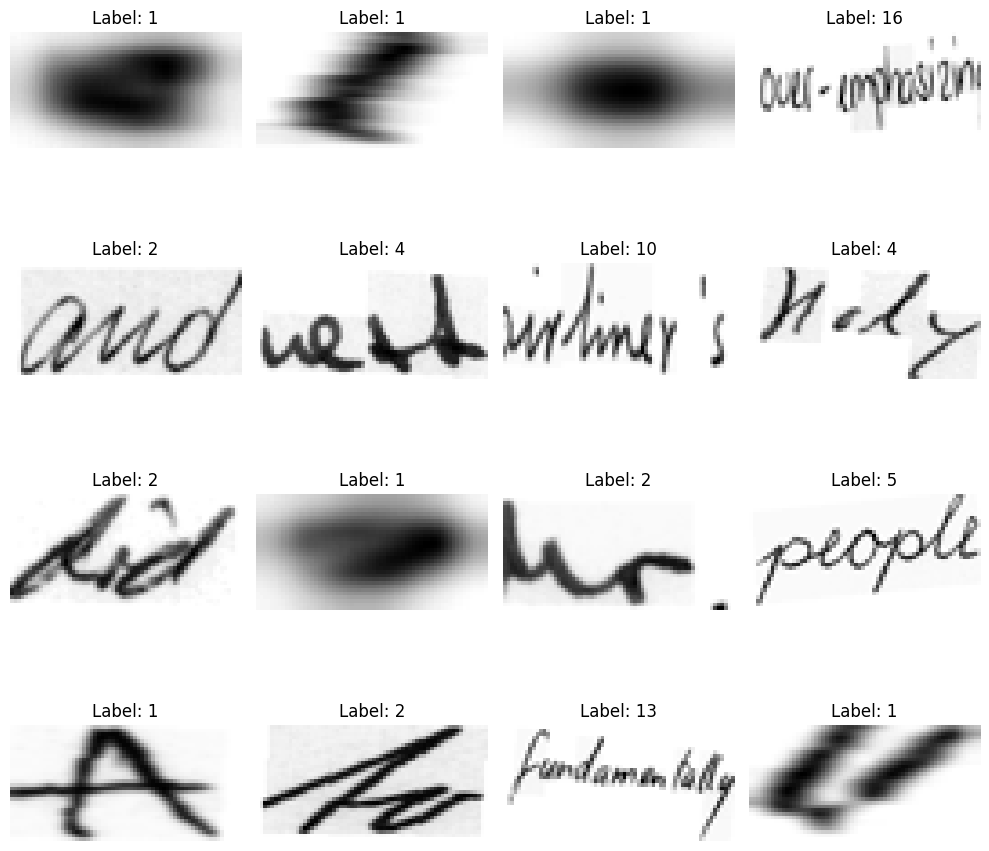

In [5]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, (x, y) in enumerate(HandWritingDataset(df.sample(16), augument=True)):
    ax = axes[i // 4, i % 4]
    ax.imshow(x.squeeze().cpu().numpy(), cmap='gray')
    ax.axis('off')
    ax.set_title(f"Label: {int(y.item() * MAX_LEN)}")
plt.tight_layout()
plt.show()

# Loader

In [6]:
train_dataset = HandWritingDataset(df_train, augument=True)
test_dataset = HandWritingDataset(df_test)
val_dataset = HandWritingDataset(df_val)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

print(train_dataset[0][0].shape)

torch.Size([1, 32, 64])


# Model

In [7]:
class HandWritingModel(nn.Module):
    def __init__(self):
        super(HandWritingModel, self).__init__()

        self.input_layer = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=(1, 4), stride=(1,4), padding=0)
        self.conv = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=(1,4), stride=(1,4), padding=0)
        self.lstm = nn.LSTM(input_size=32*32, hidden_size=64, num_layers=2, batch_first=True)
        self.flatten = nn.Flatten()
        self.output = nn.Linear(256, 1)

        self._init_weights()

    def forward(self, x):
        x = self.input_layer(x)
        x = self.pool1(x)
        x = self.conv(x)
        x = self.pool2(x)
        x = x.permute(0, 3, 2, 1)
        x = x.flatten(start_dim=2)
        x, (_, _) = self.lstm(x)
        x = self.flatten(x)
        x = self.output(x)
        return x
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

# Training

In [8]:
model = HandWritingModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
model.train()
print(model.modules())

epochs = 5
for epoch in range(epochs):
    losses = 0
    i = 0
    for x, y in train_loader:
        optimizer.zero_grad()
        y_pred = model(x).squeeze()
        loss = criterion(y_pred, y)
        losses += loss.sum().item()
        loss.backward()
        optimizer.step()
        if i % (len(train_dataset) // 800) == 0:
            print('-', end='')
        i += 1
    print(f" Epoch {epoch+1}/{epochs}, Loss: {losses/len(train_loader)}")

<generator object Module.modules at 0x7ed6d14e31d0>
----------------------------------------------------------------------------------------------------- Epoch 1/5, Loss: 0.003697756175811612
----------------------------------------------------------------------------------------------------- Epoch 2/5, Loss: 0.0022487215674021153
----------------------------------------------------------------------------------------------------- Epoch 3/5, Loss: 0.0020312155133066284
----------------------------------------------------------------------------------------------------- Epoch 4/5, Loss: 0.001854633789638827
----------------------------------------------------------------------------------------------------- Epoch 5/5, Loss: 0.001779159434368153


In [9]:
model.eval()
loader = train_loader
with torch.no_grad():
    maes = 0
    for x, y in loader:
        y_pred = model(x)
        mae = mean_absolute_error(y.cpu(), y_pred.cpu())
        # print(f'{min(y_pred.cpu()).item():.2f} {max(y_pred.cpu()).item():.2f} {y_pred.cpu().mean():.2f}')
        for i in range(len(y)):
            diff = round(abs(y[i].item() - y_pred[i].item()), 2)
            # print(diff, int(diff*MAX_LEN+0.5) * '.')
        maes += mae
    print(f"Validation MAE: {maes/len(loader)*MAX_LEN:.2f}")

Validation MAE: 0.54


In [10]:
model.eval()
loader = test_loader
with torch.no_grad():
    maes = 0
    for x, y in loader:
        y_pred = model(x)
        mae = mean_absolute_error(y.cpu(), y_pred.cpu())
        # print(f'{min(y_pred.cpu()).item():.2f} {max(y_pred.cpu()).item():.2f} {y_pred.cpu().mean():.2f}')
        for i in range(len(y)):
            diff = round(abs(y[i].item() - y_pred[i].item()), 2)
            # print(diff, int(diff*MAX_LEN+0.5) * '.')
        maes += mae
    print(f"Validation MAE: {maes/len(loader)*MAX_LEN:.2f}")

Validation MAE: 0.55
